In [1]:
import requests
import pandas as pd 
from sqlalchemy import create_engine
import mysql.connector
import pymysql
from datetime import datetime
import schedule
import time

In [2]:
# -- Fetch weather data for cities
def fetch_weather_data(cities):
    api_key = "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX"
    weather_data = {}

    for city in cities:
        api_url = f"http://api.openweathermap.org/data/2.5/weather?q={city}&appid={api_key}&units=imperial"
        response = requests.get(api_url)
    
        if response.status_code == 200:
            weather_data[city] = response.json()
        else:
            print(f"Error fetching data for {city}:", {response.status_code})
            weather_data[city] = None
        
    return weather_data
# Example usage:
cities = ["Seattle","Los Angeles","Las Vegas","Fort Worth","Miami","Nashville","New York"]
data = fetch_weather_data(cities)
print(data) #display raw JSON response 
 

{'Seattle': {'coord': {'lon': -122.3321, 'lat': 47.6062}, 'weather': [{'id': 803, 'main': 'Clouds', 'description': 'broken clouds', 'icon': '04d'}], 'base': 'stations', 'main': {'temp': 38.3, 'feels_like': 31.89, 'temp_min': 35.73, 'temp_max': 39.88, 'pressure': 1008, 'humidity': 86, 'sea_level': 1008, 'grnd_level': 998}, 'visibility': 10000, 'wind': {'speed': 9.22, 'deg': 160}, 'clouds': {'all': 75}, 'dt': 1738618866, 'sys': {'type': 2, 'id': 2041694, 'country': 'US', 'sunrise': 1738596770, 'sunset': 1738631611}, 'timezone': -28800, 'id': 5809844, 'name': 'Seattle', 'cod': 200}, 'Los Angeles': {'coord': {'lon': -118.2437, 'lat': 34.0522}, 'weather': [{'id': 721, 'main': 'Haze', 'description': 'haze', 'icon': '50d'}], 'base': 'stations', 'main': {'temp': 70.27, 'feels_like': 69.85, 'temp_min': 60.1, 'temp_max': 76.01, 'pressure': 1013, 'humidity': 61, 'sea_level': 1013, 'grnd_level': 994}, 'visibility': 8047, 'wind': {'speed': 8.05, 'deg': 210}, 'clouds': {'all': 0}, 'dt': 1738619082, 

In [3]:
def transform_data(data):
    if not data:
        return None
    
    weather_info_list = []
    for city, city_data in data.items():
        if city_data:  # Check if the city data is not None
            weather_info = {
                'City': city_data['name'],
                'Temperature': city_data['main']['temp'],
                "Feels Like (°F)": city_data["main"]["feels_like"],
                "Humidity (%)": city_data["main"]["humidity"],
                "Weather Condition": city_data["weather"][0]["description"],
                "Wind Speed (mph)": city_data["wind"]["speed"],
                'Timestamp': datetime.now()
            }
            weather_info_list.append(weather_info)
    
    df = pd.DataFrame(weather_info_list)
    return df


# Transform the fetched data
df = transform_data(data)
df # Display transformed data
 

,City,Temperature,Feels Like (°F),Humidity (%),Weather Condition,Wind Speed (mph),Timestamp
0,Seattle,38.30,31.89,86,broken clouds,9.22,2025-02-03 15:53:35.641535
1,Los Angeles,70.27,69.85,61,haze,8.05,2025-02-03 15:53:35.641535
2,Las Vegas,74.32,72.68,26,clear sky,14.97,2025-02-03 15:53:35.641535
3,Fort Worth,84.87,83.68,37,clear sky,18.41,2025-02-03 15:53:35.641535
4,Miami,79.20,79.20,80,broken clouds,9.22,2025-02-03 15:53:35.641535
5,Nashville,73.53,72.41,39,clear sky,17.27,2025-02-03 15:53:35.641535
6,New York,45.46,39.88,70,clear sky,11.50,2025-02-03 15:53:35.641535


In [4]:
# Rename columns to be MySQL-friendly
df.columns = (
    df.columns.str.strip()  # Remove leading/trailing spaces
    .str.replace(r'[^\w\s]', '', regex=True)  # Replace special characters with ''
    .str.replace(' ', '_')  # Replace spaces with underscores
)

print("Updated column names:", df.columns)  # Debugging
 

Updated column names: Index(['City', 'Temperature', 'Feels_Like_F', 'Humidity_', 'Weather_Condition',
       'Wind_Speed_mph', 'Timestamp'],
      dtype='object')


In [145]:
def create_weather_table(host="localhost", user="XXXX", password="XXXXXXXXXXX", database="weather_db"):
    try:
        conn = pymysql.connect(host=host, user=user, password=password, database=database)
        cursor = conn.cursor()

        create_table_query = """
        CREATE TABLE IF NOT EXISTS weather (
            id INT AUTO_INCREMENT PRIMARY KEY,
            City VARCHAR(255),
            Temperature FLOAT,
            Feels_Like_F FLOAT,
            Humidity_ INT,
            Weather_Condition VARCHAR(255),
            Wind_Speed_mph FLOAT,
            Timestamp DATETIME
        );
        """
        cursor.execute(create_table_query)
        conn.commit()
        cursor.close()
        conn.close()

        print("✅ Table 'weather' checked/created successfully!")
    except Exception as e:
        print(f"❌ Error creating table: {e}")

# Call this function before inserting data
create_weather_table()
 

✅ Table 'weather' checked/created successfully!


In [5]:
print(df.columns)

Index(['City', 'Temperature', 'Feels_Like_F', 'Humidity_', 'Weather_Condition',
       'Wind_Speed_mph', 'Timestamp'],
      dtype='object')


In [ ]:
def load_to_mysql(df, host="localhost", user="XXXX", password="XXXXXXXXXXX", database="weather_db"):
    if df.empty:
        print("No data to load into MySQL!")
        return
    # Create a SQLAlchemy engine
    engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}/{database}")

    # Convert datetime column to string if necessary
    if 'Timestamp' in df.columns:
        df['Timestamp'] = df['Timestamp'].astype(str)
        
    # Load DataFrame into MySQL (append mode to avoid overwriting)
    df.to_sql('weather', con=engine, if_exists='append', index=False)

    print("Data successfully loaded into MySQL!")

# Load the transformed data into MySQL
load_to_mysql(df)
 

Data successfully loaded into MySQL!


In [148]:
#def job():
#    print(f"Running job at {datetime.now()}")
#    # Fetch and process the weather data
#    cities = ["Seattle","Los Angeles","Las Vegas","Fort Worth","Miami","Nashville","New York"]
#    data = fetch_weather_data(cities)
#    df = transform_data(data)
#    load_to_mysql(df)
#    print("✅ Data pulled and loaded successfully!")

# Schedule the job every day at 7:00 AM
#schedule.every().day.at("07:00").do(job)

# Keep the script running
#while True:
#    schedule.run_pending()
#    time.sleep(60)  # Check every minute

In [ ]:
def fetch_from_mysql(host="localhost", user="XXXX", password="XXXXXXXXXXX", database="weather_db"):
    # Create a SQLAlchemy engine
    engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}/{database}")
    # Read data into a pandas DataFrame
    query = "SELECT * FROM weather"
    df = pd.read_sql(query, con=engine)  # Uses SQLAlchemy engine

    return df

# Fetch and display stored data
fetch_from_mysql()


,id,City,Temperature,Feels_Like_F,Humidity_,Weather_Condition,Wind_Speed_mph,Timestamp
0,1,Seattle,38.30,31.89,86,broken clouds,9.22,2025-02-03 15:49:01
1,2,Los Angeles,70.27,69.85,61,haze,8.05,2025-02-03 15:49:01
2,3,Las Vegas,74.32,72.68,26,clear sky,14.97,2025-02-03 15:49:01
3,4,Fort Worth,84.83,83.64,37,clear sky,18.41,2025-02-03 15:49:01
4,5,Miami,79.20,79.20,80,broken clouds,9.22,2025-02-03 15:49:01
5,6,Nashville,73.56,72.45,39,clear sky,17.27,2025-02-03 15:49:01
6,7,New York,45.46,39.88,70,clear sky,11.50,2025-02-03 15:49:01
7,8,Seattle,38.30,31.89,86,broken clouds,9.22,2025-02-03 15:53:36
8,9,Los Angeles,70.27,69.85,61,haze,8.05,2025-02-03 15:53:36
9,10,Las Vegas,74.32,72.68,26,clear sky,14.97,2025-02-03 15:53:36


In [151]:
# --- Save Data to CSV ---

# Assuming df is your DataFrame

# Path to your CSV file
csv_file_path = 'weather_data.csv'

# Write the DataFrame to a new CSV file (this will create the file if it doesn't exist)
#df.to_csv(csv_file_path, index=False)
# Append new data to the CSV while keeping headers intact
df.to_csv(csv_file_path, mode='a', header=not pd.io.common.file_exists(csv_file_path), index=False)



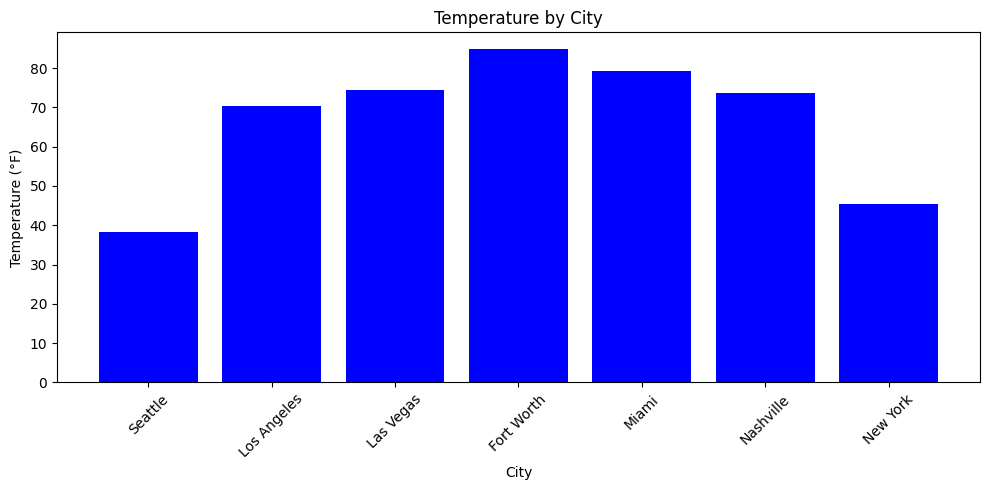

In [8]:
import matplotlib.pyplot as plt

df = fetch_from_mysql()

plt.figure(figsize=(10,5))
plt.bar(df['City'], df['Temperature'], color='blue')
plt.xlabel("City")
plt.ylabel("Temperature (°F)")
plt.title("Temperature by City")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
